In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib.request

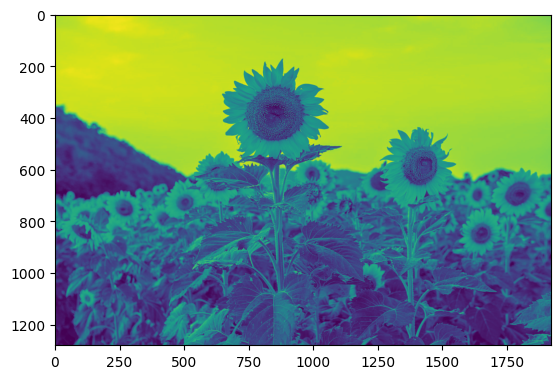

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Sunflowers")[:, :, ::-1]
im = im.astype(float).mean(2) / 255
plt.imshow(im)

(31,) (31,)


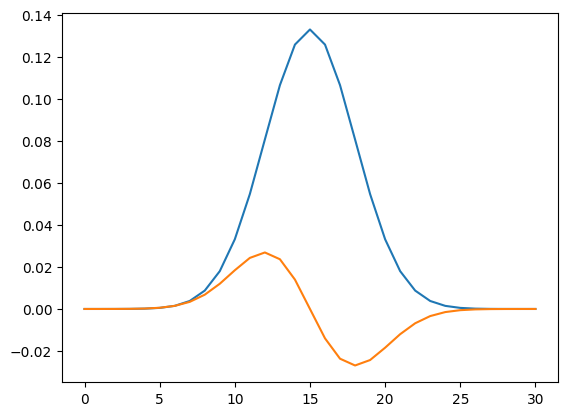

In [ ]:
def gaussian1DKernel(sigma: int, length: int = 5):
    """
    Generate the 1D gaussian kernel and its derivative
    Args:
        sigma (int): gaussian width
        length (int): length of the Gaussian kernel

    Return:
        g (np.array): gaussian kernel
        gd (np.array): derivative of gaussian kernel, g
    """
    x = np.arange(-np.ceil(length * sigma), np.ceil(length * sigma) + 1)
    constant = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    g = constant * np.exp(-(x**2) / (2 * sigma**2))
    g /= g.sum()
    gd = (-x / sigma**2) * g
    return g, gd

g, gd = gaussian1DKernel(3, 5)
print(g.shape, gd.shape)
plt.plot(g)
plt.plot(gd)

In [ ]:
def gaussianSmoothing(im: np.array, sigma: int):
    """
    Generate the gaussian smoothed image and its smoothed derivative in x and y direction
    Args:
        im (np.array): image to be smoothed
        sigma (int): gaussian width

    Return:
        I (np.array): gaussian smoothed image
        Ix (np.array): smoothed derivative of image im in x direction
        Iy (np.array): smoothed derivative of image im in y direction
    """
    g, gd = gaussian1DKernel(sigma)
    I = cv2.sepFilter2D(im, -1, g, g)
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    Iy = cv2.sepFilter2D(im, -1, g, gd)
    return I, Ix, Iy

In [36]:
def scaleSpaced(im: np.array, sigma: int, n: int) -> np.array:
    """
    Returns a list containing the scale space pyrami of original image im.
    Note that this is a simplified version with increasing widths of gaussians but no downsampling
        Args:
            im (np.array): original image
            sigma (int): standard deviation of gaussian
            n (int): iteration of scale pyramid

        Return:
            im_scales (np.array): list containing the scale space pyramids
            scales (np.array): list of scales used
    """
    im_scales = []
    scales = []
    for i in range(n):
        sigma_slice = sigma * (2**i)
        im_scale, _, _ = gaussianSmoothing(im, sigma_slice)
        im_scales.append(im_scale)
        scales.append(sigma_slice)
    return np.array(im_scales), np.array(scales)

In [38]:
sigma = 2
n_scales = 7
im_scales, scales = scaleSpaced(im, sigma, n_scales)
im_scales.shape, scales.shape

((7, 1280, 1920), (7,))

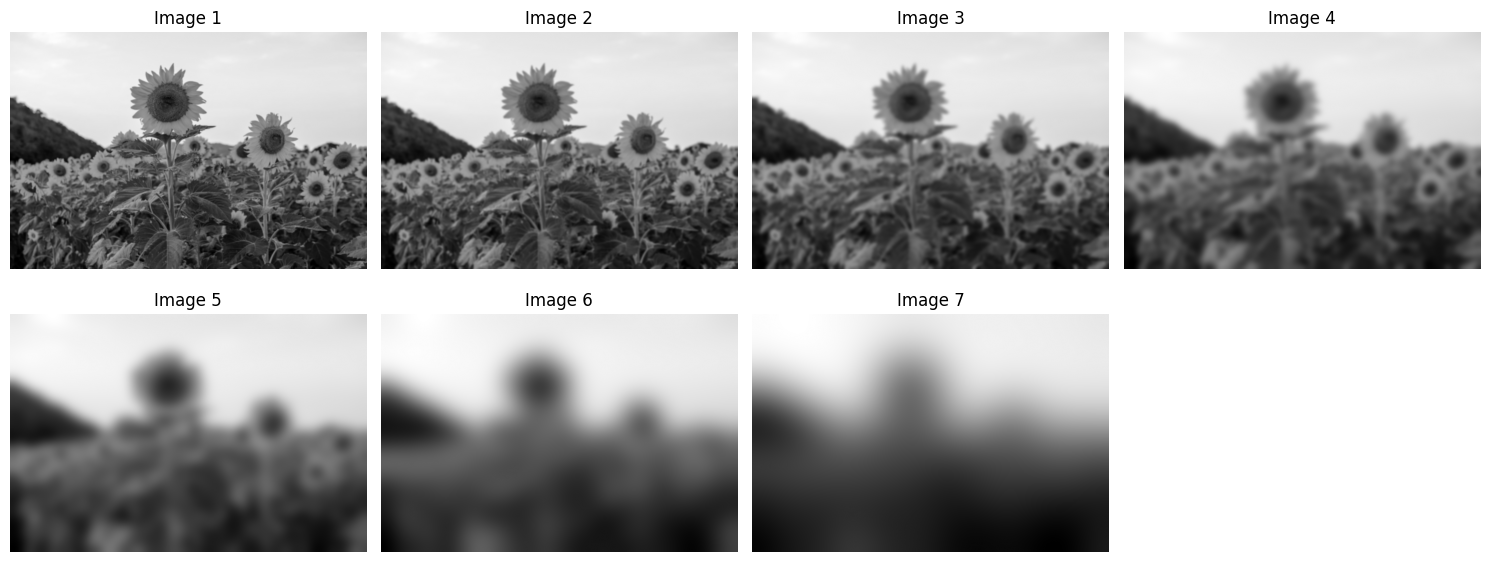

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()  # Flatten the 2D array of axes

for i in range(7):
    axes[i].imshow(im_scales[i], cmap="gray")
    axes[i].axis("off")  # Hide axes
    axes[i].set_title(f"Image {i+1}")

# Hide the extra subplot (since we have 7 images but 8 slots)
axes[7].axis("off")

plt.tight_layout()
plt.show()

In [41]:
def differenceOfGaussians(im: np.array, sigma: int, n: int):
    """
    Returns a list of scale space DoGs of the original image im
        Args:
            im (np.array): original image
            sigma (int): standard deviation of gaussian
            n (int): iteration of scale pyramid

        Return:
            DoG (np.array): list of scale space DoGs of the original image im
            scales (np.array): list of scales used
    """
    DoG = []
    im_scales, scales = scaleSpaced(im, sigma, n_scales)
    for i in range(1, n_scales):
        diff = im_scales[i] - im_scales[i - 1]
        DoG.append(diff)
    return np.array(DoG), scales

In [42]:
dogs, scales = differenceOfGaussians(im, sigma, n_scales)

In [43]:
dogs.shape

(6, 1280, 1920)

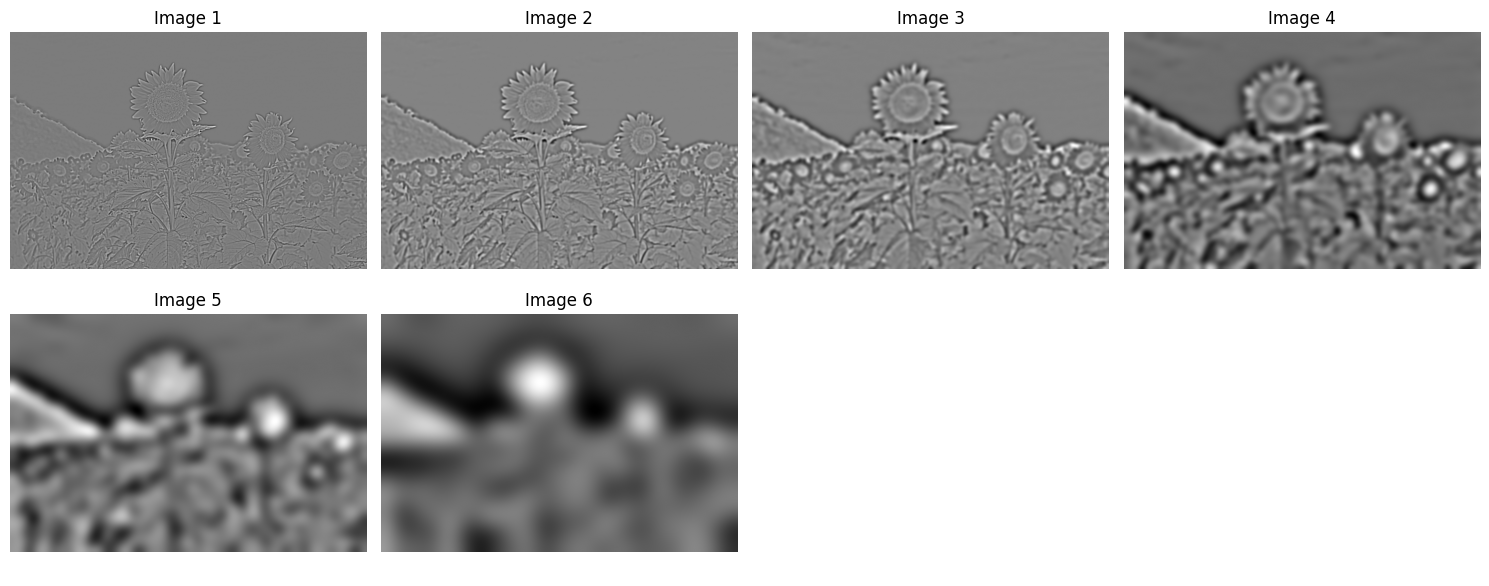

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
axes = axes.flatten()  # Flatten the 2D array of axes

for i in range(dogs.shape[0]):
    axes[i].imshow(dogs[i], cmap="gray")
    axes[i].axis("off")  # Hide axes
    axes[i].set_title(f"Image {i+1}")
# I know there is a better way to do this
axes[dogs.shape[0]].axis("off")
axes[dogs.shape[0] + 1].axis("off")
plt.tight_layout()
plt.show()

In [52]:
MaxDoG = np.array([cv2.dilate(abs(dog), np.ones((3, 3))) for dog in dogs])
MaxDoG.shape

(6, 1280, 1920)

In [64]:
    topMaxDoG = np.zeros(dogs[0].shape)
    bottomMaxDoG = np.zeros(dogs[0].shape)
    topMaxDoG.shape, bottomMaxDoG.shape

((1280, 1920), (1280, 1920))

In [65]:
absPixelValue = abs(dogs[0][0, 0])
absPixelValue > topMaxDoG[0][0, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Ex 8.3


In [69]:
def visualize_blobs(blobs, im):
    """
    Args:
        blobs(np.array) : list of detected blobs in the format (x, y, scale)
        im(np.) : BGR input image
    """
    gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # To draw colored shapes on a gray img
    bgr_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    for x, y, scale in list(blobs):
        cv2.circle(
            bgr_img, (y, x), radius=int(scale), color=(255, 0, 0), thickness=2
        )
    plt.axis("off")
    plt.imshow(bgr_img)
    plt.show()

In [78]:
def detectBlobs(im: np.array, sigma: int, n: int, tau: float):
    """
    Finds blobs with a DoG magnitude larger than threshold tau.
    Uses non maximum suppression to give a single response for each BLOB.
    Apply maximum filter for 3 slices, layer below, current layer and layer above.
        Args:
            im (np.array): original image
            sigma (int): standard deviation of gaussian
            n (int): iteration of scale pyramid
            tau (float): threshold for blob detection

        Return:
            blobs (np.array): list of coordinates of blobs with their scale
    """
    DoGs, scales = differenceOfGaussians(im, sigma, n)
    MaxDoG = [cv2.dilate(abs(dog), np.ones((3, 3))) for dog in DoGs]
    topMaxDoG = np.zeros(DoGs.shape[0])
    bottomMaxDoG = np.zeros(DoGs.shape[0])
    blobs = []
    prev_blobs = 0
    for i in range(DoGs.shape[0]):
        # first image, no top layer
        if i == 0:
          topMaxDoG = np.zeros(DoGs[0].shape)
          bottomMaxDoG = MaxDoG[i + 1]
        elif i == DoGs.shape[0] - 1:
          topMaxDoG = MaxDoG[i - 1]
          bottomMaxDoG = np.zeros(DoGs[0].shape)
        else:
          topMaxDoG = MaxDoG[i - 1]
          bottomMaxDoG = MaxDoG[i + 1]
        for j in range(DoGs.shape[1]):
          for k in range(DoGs.shape[2]):
            absPixelValue = abs(DoGs[i][j, k])
            # if larger than all layers
            if absPixelValue > tau and (absPixelValue > topMaxDoG[j, k]) and (absPixelValue > bottomMaxDoG[j, k]):
              blobs.append((j, k, scales[i]))
        # Calculate how many new blobs detected in this DoG
        print(f"No. of blobs detected in DoG {i}: {len(blobs)-prev_blobs}")
        prev_blobs = len(blobs)
    return np.array(blobs)

In [84]:
sigma = 2
n_scales = 6
tau = 0.1
blobs = detectBlobs(im, sigma, n_scales, tau)

No. of blobs detected in DoG 0: 3581
No. of blobs detected in DoG 1: 6786
No. of blobs detected in DoG 2: 13010
No. of blobs detected in DoG 3: 19052
No. of blobs detected in DoG 4: 43038


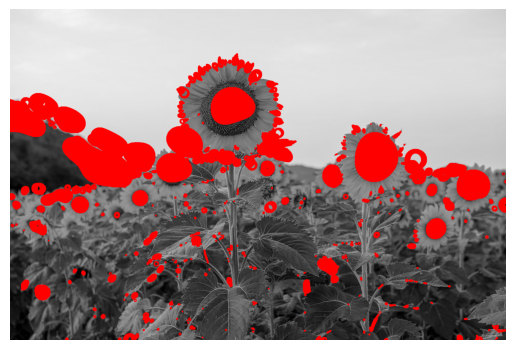

In [85]:
visualize_blobs(blobs, cv2.imread("/content/drive/MyDrive/Sunflowers")[:, :, ::-1])

## Ex 8.4

In [86]:
def transformIm(im: np.array, theta: float, s: float):
    """
    Returns a scaled and rotated image from the original image
        Args:
            im (np.array): original image
            theta (float): rotation angle
            s (float): scaling factor

        Return:
            rotated_image (np.array): scaled and rotated image
    """
    height, width = im.shape[:2]
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=theta, scale=s)
    rotated_image = cv2.warpAffine(src=im, M=rotate_matrix, dsize=(width, height))
    return rotated_image


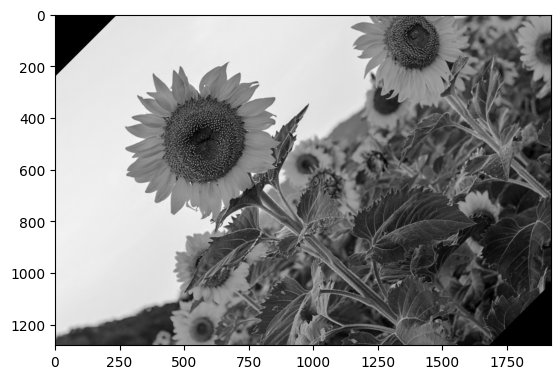

In [87]:
rotated_image = transformIm(im, 45, 1.5)
plt.imshow(rotated_image, cmap="gray")

## Ex 8.5

In [111]:
im = cv2.imread("/content/drive/MyDrive/Sunflowers")[:, :, ::-1].mean(2).astype(np.uint8)
r_im = transformIm(im, 45, 1.5).astype(np.uint8)

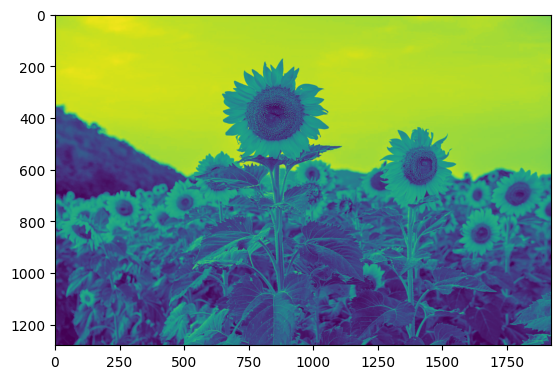

In [112]:
plt.imshow(im)

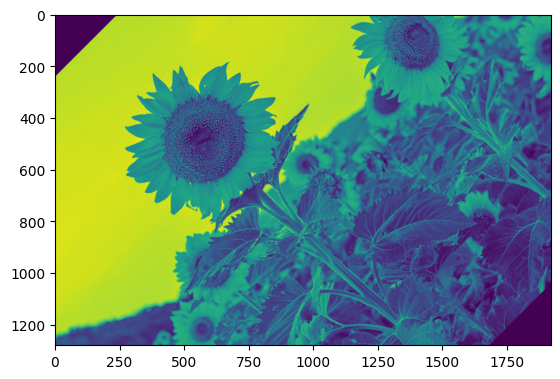

In [113]:
plt.imshow(r_im)

In [116]:
sift = cv2.SIFT_create()

# Convert im and rotated_image to uint8 before detecting keypoints
kp1, des1 = sift.detectAndCompute(im, None)
kp2, des2 = sift.detectAndCompute(r_im, None)

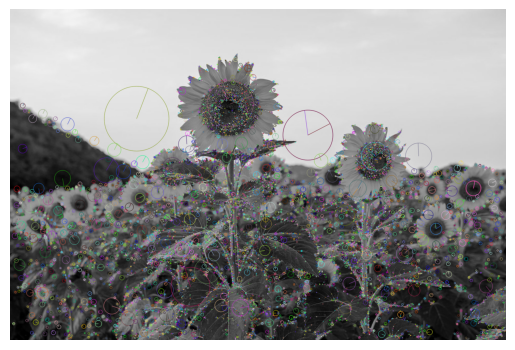

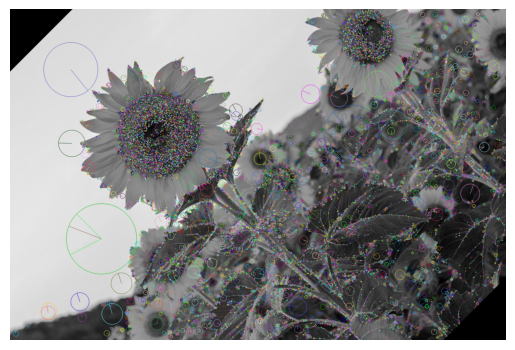

In [117]:
img = cv2.drawKeypoints(
    im, kp1, im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

r_img = cv2.drawKeypoints(
    r_im, kp2, r_im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

# Plot features in both images.
plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(r_img)
plt.axis("off")
plt.show()

Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html

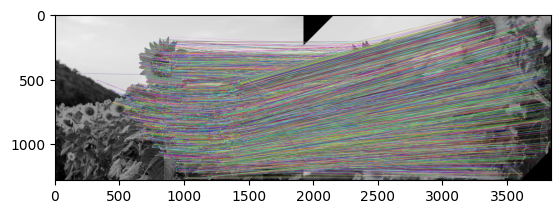

In [123]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
# Initialize img3 with the first image to draw matches on
img3 = im.copy()
img3 = cv2.drawMatchesKnn(im,kp1,r_im,kp2,good, outImg=img3, flags=2)

plt.imshow(img3)

## r2d2
https://github.com/abdollah-semej/image-matching-with-r2d2-and-opencv
